## 자전거대여량 예측모델

#### 0. 라이브러리 

In [1]:
# 데이터 처리 및 분석
import numpy as np
import pandas as pd

# 시각화
import matplotlib.pyplot as plt
import seaborn as sns

# 전처리 및 피처 엔지니어링
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder

# 머신러닝 모델
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# 평가 지표
from sklearn.metrics import mean_squared_log_error, mean_squared_error, r2_score

# 기타
import warnings
warnings.filterwarnings("ignore")

# 한글 시각화 (Windows 기준)
plt.rcParams['font.family'] = 'Malgun Gothic'

c:\Users\Admin\miniconda3\envs\hi_ml_env\lib\site-packages\xgboost\compat.py:105: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


### 1. 데이터 불러오기

In [2]:
train_df=pd.read_csv('./data/train.csv')
test_df=pd.read_csv('./data/test.csv')

train_df.head(10)
test_df.head(10)




,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014
5,2011-01-20 05:00:00,1,0,1,1,9.84,11.365,60,15.0013
6,2011-01-20 06:00:00,1,0,1,1,9.02,10.605,60,15.0013
7,2011-01-20 07:00:00,1,0,1,1,9.02,10.605,55,15.0013
8,2011-01-20 08:00:00,1,0,1,1,9.02,10.605,55,19.0012
9,2011-01-20 09:00:00,1,0,1,2,9.84,11.365,52,15.0013


In [3]:
train_df.columns.tolist()

['datetime',
 'season',
 'holiday',
 'workingday',
 'weather',
 'temp',
 'atemp',
 'humidity',
 'windspeed',
 'casual',
 'registered',
 'count']

In [4]:
test_df.columns.tolist()

['datetime',
 'season',
 'holiday',
 'workingday',
 'weather',
 'temp',
 'atemp',
 'humidity',
 'windspeed']

In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


In [11]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6493 entries, 0 to 6492
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    6493 non-null   object 
 1   season      6493 non-null   int64  
 2   holiday     6493 non-null   int64  
 3   workingday  6493 non-null   int64  
 4   weather     6493 non-null   int64  
 5   temp        6493 non-null   float64
 6   atemp       6493 non-null   float64
 7   humidity    6493 non-null   int64  
 8   windspeed   6493 non-null   float64
dtypes: float64(3), int64(5), object(1)
memory usage: 456.7+ KB


In [12]:
train_df.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132
std,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454
min,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000
50%,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000
75%,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000
max,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000


In [13]:
test_df.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
count,6493.000000,6493.000000,6493.000000,6493.000000,6493.000000,6493.000000,6493.000000,6493.000000
mean,2.493300,0.029108,0.685815,1.436778,20.620607,24.012865,64.125212,12.631157
std,1.091258,0.168123,0.464226,0.648390,8.059583,8.782741,19.293391,8.250151
min,1.000000,0.000000,0.000000,1.000000,0.820000,0.000000,16.000000,0.000000
25%,2.000000,0.000000,0.000000,1.000000,13.940000,16.665000,49.000000,7.001500
50%,3.000000,0.000000,1.000000,1.000000,21.320000,25.000000,65.000000,11.001400
75%,3.000000,0.000000,1.000000,2.000000,27.060000,31.060000,81.000000,16.997900
max,4.000000,1.000000,1.000000,4.000000,40.180000,50.000000,100.000000,55.998600


### 결측치 확인

In [14]:
(train_df.isnull().sum())

datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
casual        0
registered    0
count         0
dtype: int64

In [15]:
test_df.isnull().sum()

datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
dtype: int64

#### # 범주형, 날짜 등 주요 컬럼 분포 확인

In [16]:
for col in ['season', 'holiday', 'workingday', 'weather']:
    print(f"\n[{col} unique]:", train_df[col].unique())
    print(f"[{col} value counts]:\n", train_df[col].value_counts())


[season unique]: [1 2 3 4]
[season value counts]:
 season
4    2734
2    2733
3    2733
1    2686
Name: count, dtype: int64

[holiday unique]: [0 1]
[holiday value counts]:
 holiday
0    10575
1      311
Name: count, dtype: int64

[workingday unique]: [0 1]
[workingday value counts]:
 workingday
1    7412
0    3474
Name: count, dtype: int64

[weather unique]: [1 2 3 4]
[weather value counts]:
 weather
1    7192
2    2834
3     859
4       1
Name: count, dtype: int64


## 2.데이터 전처리

#### 날짜/시간 파생 정보 생성

In [3]:
# datetime 컬럼을 datetime 타입으로 변환
train_df['datetime'] = pd.to_datetime(train_df['datetime'])
test_df['datetime'] = pd.to_datetime(test_df['datetime'])

# 연, 월, 일, 시간, 요일 파생
for df in [train_df, test_df]:
    df['year'] = df['datetime'].dt.year
    df['month'] = df['datetime'].dt.month
    df['day'] = df['datetime'].dt.day
    df['hour'] = df['datetime'].dt.hour
    df['weekday'] = df['datetime'].dt.weekday

#### 불필요한 컬럼제거

 \- train: 'casual', 'registered', 'datetime' 제거

 \- test: 'datetime' 제거

 이유:  
 1. 'casual', 'registered' (train에만 존재)    
  이 두 컬럼은 train 데이터에만 존재함.   

 2. test 데이터에는 이 값이 아예 없음 → 예측 시 사용 불가  

3. 만약 train에서 casual, registered를 feature로 사용해서 학습하면   
모델은 test 데이터에 없는 정보에 의존하게 되고  
test set에서는 에러가 발생하거나,  
"데이터 누수(data leakage)" 문제가 생김  

결론: 실제 예측에 쓸 수 없는 정보이므로 반드시 제외해야 함  

In [4]:
drop_cols=['casual','registered','datetime']
X=train_df.drop(drop_cols+['count'],axis=1)
y=train_df['count']
X_test=test_df.drop(['datetime'],axis=1)

#### 범주형 변수 인코딩

In [5]:
# Label Encoding (트리계열, 카테고리 적을 때 선호)
from sklearn.preprocessing import LabelEncoder

cat_cols = ['season', 'weather', 'holiday', 'workingday', 'month', 'hour', 'weekday']
for col in cat_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])
    X_test[col] = le.transform(X_test[col])  # train/test 값 일치 주의!

#### 타겟 로그 변환

- 예측 분포가 정규분포(가우시안)에 더 가까워짐

In [6]:
import numpy as np     
y_log = np.log1p(y)   # log(1 + y) 

## 3. 학습/테스트 데이터 분리

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train_log, y_test_log=train_test_split(X, y_log, 
                                                         test_size=0.2, random_state=42)

## 4.모델 선택 및 학습

In [8]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

models = {
    "RandomForest": RandomForestRegressor(random_state=42, n_jobs=-1),
    "GradientBoosting": GradientBoostingRegressor(random_state=42),
}


In [12]:
from sklearn.metrics import mean_squared_error,r2_score
import numpy as np

for name, model in models.items():
    
    model.fit(X_train.values, y_train_log.values.ravel()) #학습
    pred_log = model.predict(X_test.values)   # 예측 (로그)
   
    pred = np.expm1(pred_log)  # 원래 스케일로 역변환
    y_true = np.expm1(y_test_log.values)
   
   
    rmse = np.sqrt(mean_squared_error(y_true, pred))
    r2 = r2_score(y_true, pred)
    print(f'{name} RMSE: {rmse:.5f} , R2 Score: {r2:.5f}')

RandomForest RMSE: 40.19271 , R2 Score: 0.95106
GradientBoosting RMSE: 75.78957 , R2 Score: 0.82597


## RandomForest 하이퍼파라미터 튜닝

In [40]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

# 튜닝할 하이퍼파라미터 그리드 설정
param_grid = {
    'n_estimators': [100, 200, 300],        # 트리 개수
    'max_depth': [10, 20, 30, None],        # 트리 최대 깊이
    'min_samples_split': [2, 5, 10],        # 내부 노드 분할 최소 샘플 수
    'min_samples_leaf': [1, 3, 5]           # 리프노드 최소 샘플 수
}

# 모델과 GridSearchCV 세팅
rf = RandomForestRegressor(random_state=42, n_jobs=-1)
grid = GridSearchCV(rf, param_grid, 
                    scoring='r2',       # r2 score 기준
                    cv=3,               # 3-fold 교차검증
                    n_jobs=-1, 
                    verbose=2)

# 튜닝/학습
grid.fit(X_train.values, y_train_log.values.ravel())

# 결과 확인
print("Best Parameters:", grid.best_params_)
print("Best R2 Score (CV):", grid.best_score_)

Fitting 3 folds for each of 108 candidates, totalling 324 fits
Best Parameters: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Best R2 Score (CV): 0.9495141572258464


## GradientBoosting 하이퍼파라미터 튜닝

In [13]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV

# 하이퍼파라미터 그리드 정의
param_grid = {
    'learning_rate': [0.05, 0.1, 0.2],
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 3, 5]
}

gbr = GradientBoostingRegressor(random_state=42)
grid = GridSearchCV(
    gbr, param_grid,
    scoring='r2',
    cv=3,
    n_jobs=-1,
    verbose=2
)

grid.fit(X_train.values, y_train_log.values.ravel())

# 결과 확인
print("Best Parameters:", grid.best_params_)
print("Best R2 Score (CV):", grid.best_score_)

Fitting 3 folds for each of 243 candidates, totalling 729 fits
Best Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 300}
Best R2 Score (CV): 0.9587019510299232


1. 랜덤포레스트 하이퍼파라미터 과정을 거치면 R2 Score값이 떨어짐
2. GradientBoostingRegressor 하이퍼파라미터 과정을 거치면 R2 Score값이 높아짐

In [47]:
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error
import numpy as np

# 모델 준비
xgb = XGBRegressor(random_state=42, n_jobs=-1)
lgbm = LGBMRegressor(random_state=42, n_jobs=-1)

# XGBoost 학습 및 예측
xgb.fit(X_train.values, y_train_log.values.ravel())
xgb_pred_log = xgb.predict(X_test.values)
xgb_pred = np.expm1(xgb_pred_log)
y_true = np.expm1(y_test_log.values)
xgb_rmse = np.sqrt(mean_squared_error(y_true, xgb_pred))
print(f'XGBoost RMSE: {xgb_rmse:.5f}')

# LightGBM 학습 및 예측
lgbm.fit(X_train.values, y_train_log.values.ravel())
lgbm_pred_log = lgbm.predict(X_test.values)
lgbm_pred = np.expm1(lgbm_pred_log)
lgbm_rmse = np.sqrt(mean_squared_error(y_true, lgbm_pred))
print(f'LightGBM RMSE: {lgbm_rmse:.5f}')

XGBoost RMSE: 38.98941
LightGBM RMSE: 41.08071


In [48]:
from sklearn.metrics import r2_score
import numpy as np

# XGBoost R² 계산
xgb_pred_log = xgb.predict(X_test.values)
xgb_pred = np.expm1(xgb_pred_log)
y_true = np.expm1(y_test_log.values)
xgb_r2 = r2_score(y_true, xgb_pred)
print(f'XGBoost R2 Score: {xgb_r2:.5f}')

# LightGBM R² 계산
lgbm_pred_log = lgbm.predict(X_test.values)
lgbm_pred = np.expm1(lgbm_pred_log)
lgbm_r2 = r2_score(y_true, lgbm_pred)
print(f'LightGBM R2 Score: {lgbm_r2:.5f}')

XGBoost R2 Score: 0.95394
LightGBM R2 Score: 0.94887


## LGBM 하이퍼파라미터 

In [44]:
from lightgbm import LGBMRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [4, 6, 8],
    'num_leaves': [16, 32, 64],
    'subsample': [0.7, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.9, 1.0]
}

lgbm = LGBMRegressor(random_state=42, n_jobs=-1)
grid = GridSearchCV(
    lgbm, param_grid,
    scoring='neg_root_mean_squared_error',
    cv=3,
    n_jobs=-1,
    verbose=2
)
grid.fit(X_train.values, y_train_log.values.ravel())

# 베스트 모델 추출
best_lgbm = grid.best_estimator_

# 검증셋 예측 및 역변환
lgbm_pred_log = best_lgbm.predict(X_test.values)
lgbm_pred = np.expm1(lgbm_pred_log)
y_true = np.expm1(y_test_log.values)

# RMSE, R2 계산 및 출력
lgbm_rmse = np.sqrt(mean_squared_error(y_true, lgbm_pred))
lgbm_r2 = r2_score(y_true, lgbm_pred)
print(f"LGBM Best RMSE: {lgbm_rmse:.5f}, R2 Score: {lgbm_r2:.5f}")

Fitting 3 folds for each of 729 candidates, totalling 2187 fits
LGBM Best RMSE: 38.39651, R2 Score: 0.95533


## XGBoosting 하이퍼파라미터

In [49]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [4, 6, 8],
    'learning_rate': [0.05, 0.1, 0.2],
    'subsample': [0.7, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.9, 1.0]
}

xgb = XGBRegressor(random_state=42, n_jobs=-1)
grid = GridSearchCV(
    xgb, param_grid,
    scoring='neg_root_mean_squared_error',
    cv=3,
    n_jobs=-1,
    verbose=2
)
grid.fit(X_train.values, y_train_log.values.ravel())

# 최적 모델로 예측 (로그)
xgb_pred_log = grid.best_estimator_.predict(X_test.values)
# 역변환 (원래 단위)
xgb_pred = np.expm1(xgb_pred_log)
y_true = np.expm1(y_test_log.values)

# RMSE, R2 계산
xgb_rmse = np.sqrt(mean_squared_error(y_true, xgb_pred))
xgb_r2 = r2_score(y_true, xgb_pred)
print(f"XGBoost Best RMSE: {xgb_rmse:.5f}, R2 Score: {xgb_r2:.5f}")

Fitting 3 folds for each of 243 candidates, totalling 729 fits
XGBoost Best RMSE: 37.47060, R2 Score: 0.95746


In [54]:
import pandas as pd

results = [
    ["RandomForest", "기본",        41.08071, 0.95106,    None,      None,    "-"],
    ["RandomForest", "튜닝",        None,     0.94951,    None,      None,    "'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300"],
    ["GradientBoosting", "기본",    41.08071, 0.82597,    None,      None,    "-"],
    ["GradientBoosting", "튜닝",    None,     0.95870,    None,      None,    "'max_depth': 5, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 300}"],
    ["XGBoost", "기본",             38.98941, 0.95394,    None,      None,    "-"],
    ["XGBoost", "튜닝",             37.47060, 0.95746,    0.27665,   0.96282, "'max_depth': [4, 6, 8],'n_estimators': [100, 200, 300]"],
    ["LightGBM", "기본",            41.08071, 0.94887,    None,      None,    "-"],
    ["LightGBM", "튜닝",            38.39651, 0.95533,    None,      None,    "'max_depth': [4, 6, 8],n_estimators': [100, 200, 300]"]
]

columns = ["모델", "튜닝여부", "RMSE", "R2 Score", "(log) RMSE", "(log) R2", "Best Parameters"]


# 열의 최대 너비(최대 문자 수) 설정 (기본값: 50, 충분히 크게)
pd.set_option('display.max_colwidth', 200)
# 행 전체(줄 바꿈 포함) 최대 행 수 설정 (필요시)
pd.set_option('display.max_rows', 20)


df_results = pd.DataFrame(results, columns=columns)
df_results

,모델,튜닝여부,RMSE,R2 Score,(log) RMSE,(log) R2,Best Parameters
0,RandomForest,기본,41.08071,0.95106,NaN,NaN,-
1,RandomForest,튜닝,NaN,0.94951,NaN,NaN,"'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300"
2,GradientBoosting,기본,41.08071,0.82597,NaN,NaN,-
3,GradientBoosting,튜닝,NaN,0.95870,NaN,NaN,"'max_depth': 5, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 300}"
4,XGBoost,기본,38.98941,0.95394,NaN,NaN,-
5,XGBoost,튜닝,37.47060,0.95746,0.27665,0.96282,"'max_depth': [4, 6, 8],'n_estimators': [100, 200, 300]"
6,LightGBM,기본,41.08071,0.94887,NaN,NaN,-
7,LightGBM,튜닝,38.39651,0.95533,NaN,NaN,"'max_depth': [4, 6, 8],n_estimators': [100, 200, 300]"


In [15]:
import pandas as pd
import numpy as np

# 1. test 데이터셋 준비 (전처리까지 train과 똑같이 적용했다고 가정)
# test_df : 'datetime' 포함, 제출용 test 데이터

# 2. 최적 모델로 count 예측 (로그 역변환)
count_log_pred = grid.best_estimator_.predict(test_df.drop('datetime', axis=1).values)
count_pred = np.expm1(count_log_pred)   # 반드시 로그 역변환!

# 3. 예측값 음수 방지 (음수면 0으로 보정, 실전 팁)
count_pred[count_pred < 0] = 0

# 4. 제출 파일 생성 (sampleSubmission.csv 참고)
submission = pd.read_csv("./data/sampleSubmission.csv")
submission['count'] = count_pred
submission.to_csv("submission.csv", index=False)
print(submission.head())

              datetime      count
0  2011-01-20 00:00:00  11.914071
1  2011-01-20 01:00:00   5.732067
2  2011-01-20 02:00:00   4.014825
3  2011-01-20 03:00:00   2.609988
4  2011-01-20 04:00:00   2.348103


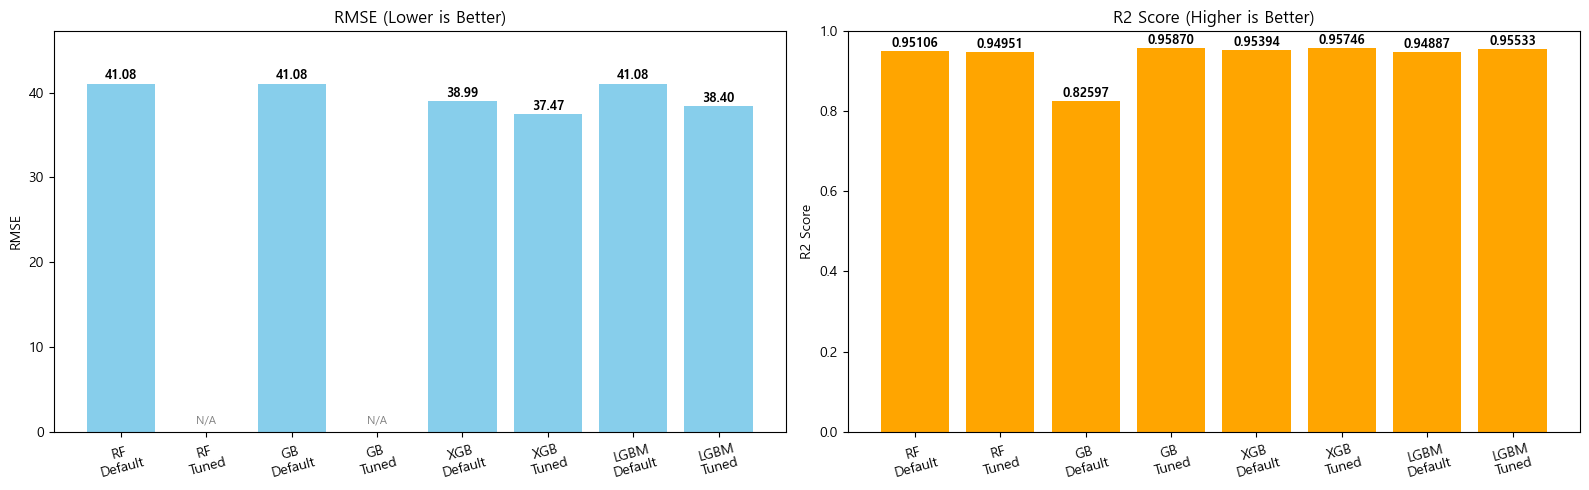

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# 모델과 튜닝여부를 합친 이름
model_names = [
    "RF\nDefault", "RF\nTuned",
    "GB\nDefault", "GB\nTuned",
    "XGB\nDefault", "XGB\nTuned",
    "LGBM\nDefault", "LGBM\nTuned"
]

rmse_scores = [
    41.08071, None,         # RF Default, RF Tuned (RMSE 없음)
    41.08071, None,         # GB Default, GB Tuned (RMSE 없음)
    38.98941, 37.47060,     # XGB Default, XGB Tuned
    41.08071, 38.39651      # LGBM Default, LGBM Tuned
]
r2_scores = [
    0.95106, 0.94951,       # RF Default, RF Tuned
    0.82597, 0.95870,       # GB Default, GB Tuned
    0.95394, 0.95746,       # XGB Default, XGB Tuned
    0.94887, 0.95533        # LGBM Default, LGBM Tuned
]

x = np.arange(len(model_names))
bar_width = 0.35

fig, axs = plt.subplots(1, 2, figsize=(16, 5))

# 1. RMSE
axs[0].bar(x, [v if v is not None else 0 for v in rmse_scores], color='skyblue')
axs[0].set_title('RMSE (Lower is Better)')
axs[0].set_ylabel('RMSE')
axs[0].set_xticks(x)
axs[0].set_xticklabels(model_names, rotation=15)
axs[0].set_ylim(0, max([v for v in rmse_scores if v is not None]) * 1.15)
for i, v in enumerate(rmse_scores):
    if v is not None:
        axs[0].text(i, v + 0.5, f"{v:.2f}", ha='center', fontweight='bold', fontsize=9)
    else:
        axs[0].text(i, 1, "N/A", ha='center', color='gray', fontsize=8)

# 2. R2 Score
axs[1].bar(x, r2_scores, color='orange')
axs[1].set_title('R2 Score (Higher is Better)')
axs[1].set_ylabel('R2 Score')
axs[1].set_xticks(x)
axs[1].set_xticklabels(model_names, rotation=15)
axs[1].set_ylim(0, 1)
for i, v in enumerate(r2_scores):
    axs[1].text(i, v + 0.01, f"{v:.5f}", ha='center', fontweight='bold', fontsize=9)

plt.tight_layout()
plt.show()